## Observations and Insights 

 - The bar plot tells us that there were sufficient sample data points taken for each of the different drug regimens. They all had above 140.
 - The box and whisker plot shows that the Capomulin and Ramicane treatements similarly effected the final tumor volume (mm3). Infubinol and Ceftamine had similar effectiveness but were both less effective than the Capomulin and Ramicane treatments.
 - The scatter plot show linear regression equation tells us that for every gram of weight in a mouse we can expect a .95 increase to the average tumor volume (mm3). The R-squared value of 0.84 tells us there is a strong correlation between the two variables. 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)
# Combine the data into a single dataset
merged_df = pd.merge(mouse_metadata,study_results, how='outer', on='Mouse ID')
# Display the data table for preview
merged_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
# Checking the number of mice.
merged_df['Mouse ID'].count()


1893

In [3]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
merged_df = merged_df.drop_duplicates(['Mouse ID', 'Timepoint'])

In [4]:
# Checking the number of mice in the clean DataFrame.
merged_df['Mouse ID'].count()

1888

## Summary Statistics

In [5]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
summary = merged_df.groupby('Drug Regimen')
# Mean, median, variance, standard deviation, and SEM of the tumor volume. 
tumor_mean = summary['Tumor Volume (mm3)'].mean()
tumor_median = summary['Tumor Volume (mm3)'].median()
tumor_sd = summary['Tumor Volume (mm3)'].std()
tumor_sem = summary['Tumor Volume (mm3)'].sem()
# Assemble the resulting series into a single summary dataframe.
final_summary = pd.DataFrame({'Mean':tumor_mean,'Median':tumor_median,
                              'Standard Deviation':tumor_sd,
                             'SEM':tumor_sem})
final_summary.head()


,Mean,Median,Standard Deviation,SEM
Drug Regimen,,,,
Capomulin,40.675741,41.557809,4.994774,0.329346
Ceftamin,52.591172,51.776157,6.268188,0.469821
Infubinol,52.884795,51.820584,6.567243,0.492236
Ketapril,55.235638,53.698743,8.279709,0.603860
Naftisol,54.331565,52.509285,8.134708,0.596466


## Bar and Pie Charts

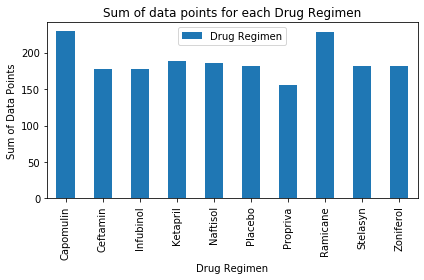

In [6]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
grouped_df = merged_df.groupby('Drug Regimen')
grouped_df_count = pd.DataFrame(summary['Drug Regimen'].count())
chart = grouped_df_count.plot(kind='bar',title='Sum of data points for each Drug Regimen')
chart.set_xlabel('Drug Regimen')
chart.set_ylabel('Sum of Data Points')
plt.tight_layout()


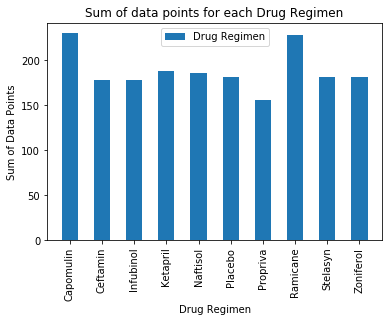

In [7]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
x_axis = np.arange(len(grouped_df_count))
tick_locations = [value for value in x_axis]
plt.bar(x_axis, grouped_df_count['Drug Regimen'], width = .5)
plt.xticks(tick_locations, list(grouped_df_count.index), rotation='vertical')
plt.xlim(-0.7, len(x_axis)-0.3)
plt.ylim(0, max(grouped_df_count["Drug Regimen"])*1.05)
plt.title("Sum of data points for each Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Sum of Data Points")
column_name = ["Drug Regimen"]
plt.legend(column_name,loc="best")

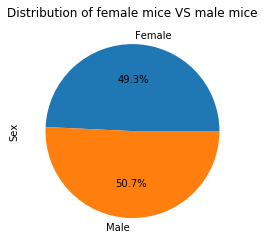

In [8]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
gender_grouped = merged_df.groupby('Sex')
gender_grouped_count = pd.DataFrame(gender_grouped['Sex'].count())
gender_grouped_count.plot(kind='pie', y='Sex', 
                          title='Distribution of female mice VS male mice',legend=False, autopct='%1.1f%%')

Text(0, 0.5, 'Sex')

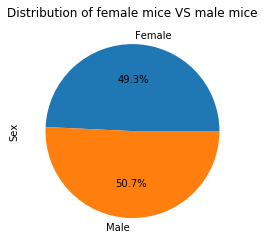

In [9]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
genders = list(gender_grouped_count.index.values)
genders_counted = gender_grouped_count['Sex']
plt.pie(genders_counted, labels=genders, autopct='%1.1f%%')
plt.title('Distribution of female mice VS male mice')
plt.ylabel('Sex')

## Quartiles, Outliers and Boxplots

In [10]:
# Get the last (greatest) timepoint for each mouse
max_tp_df = pd.DataFrame(merged_df.groupby('Mouse ID')['Timepoint'].max().sort_values()).rename(columns={'Timepoint': 'max_timepoint'}).reset_index()
max_tp_df

# Merge max timepoint onto data_df
merged_df2 = pd.merge(merged_df, max_tp_df, on='Mouse ID')
merged_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [11]:
plot_labels = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
# Create empty list to fill with tumor vol data (for plotting)
tumor_vol_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for drug in plot_labels:
    # Create new data frame that contains only info on the drug
    temp_df = merged_df2.loc[merged_df2['Drug Regimen'] == drug]
    # Create new data frame that contains only the max vale timepoints
    final_vol_df = temp_df.loc[temp_df['Timepoint'] == temp_df['max_timepoint']]
    # Save all the max values for that drug into tumor_vol_data
    values = final_vol_df['Tumor Volume (mm3)']
    tumor_vol_data.append(values)
    # Print out information
    quartiles = values.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    print(f'IQR for {drug}: {iqr}')
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f'Lower Bound for {drug}: {lower_bound}')
    print(f'Upper Bound for {drug}: {upper_bound}')
    outliers_count = (values.loc[(final_vol_df['Tumor Volume (mm3)'] >= upper_bound) | (final_vol_df['Tumor Volume (mm3)'] <= lower_bound)]).count()
    print(f'Number of {drug} outliers: {outliers_count}')

IQR for Capomulin: 7.781863460000004
Lower Bound for Capomulin: 20.70456164999999
Upper Bound for Capomulin: 51.83201549
Number of Capomulin outliers: 0
IQR for Ramicane: 9.098536719999998
Lower Bound for Ramicane: 17.912664470000003
Upper Bound for Ramicane: 54.30681135
Number of Ramicane outliers: 0
IQR for Infubinol: 11.477135160000003
Lower Bound for Infubinol: 36.83290494999999
Upper Bound for Infubinol: 82.74144559000001
Number of Infubinol outliers: 1
IQR for Ceftamin: 15.577752179999997
Lower Bound for Ceftamin: 25.355449580000002
Upper Bound for Ceftamin: 87.66645829999999
Number of Ceftamin outliers: 0


<function matplotlib.pyplot.show(*args, **kw)>

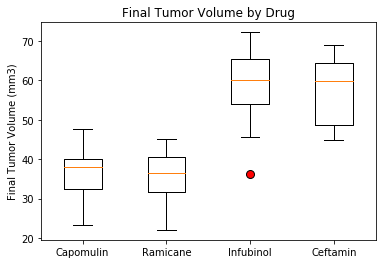

In [12]:
flierprops = dict(marker='o', markerfacecolor='r', markersize = 8, markeredgecolor = 'black')
plt.boxplot(tumor_vol_data, flierprops=flierprops)
plt.title('Final Tumor Volume by Drug')
plt.ylabel('Final Tumor Volume (mm3)')
plt.xticks([1,2,3,4], ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin'])
plt.show

## Line and Scatter Plots

Text(0.5, 1.0, 'Capomulin Treatment of Mouse s185')

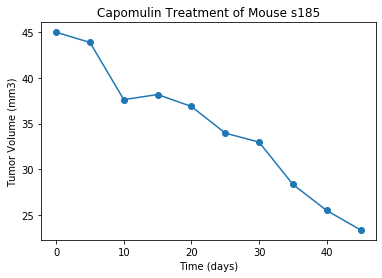

In [13]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
# Find data points of mice treated with Capomulin
mouse = merged_df.loc[merged_df['Mouse ID'] == 's185']
plt.plot(mouse['Timepoint'], mouse['Tumor Volume (mm3)'], marker = 'o')
plt.xlabel("Time (days)")
plt.ylabel("Tumor Volume (mm3)")
plt.title("Capomulin Treatment of Mouse s185")


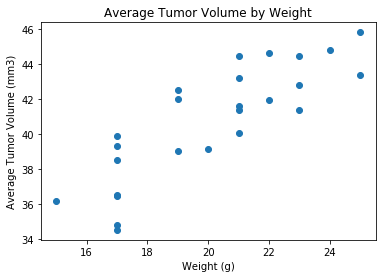

In [14]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
capomulin_df = merged_df[merged_df['Drug Regimen'] == 'Capomulin']
# Get avg tumor volume for each mouse
avg_vol_df = pd.DataFrame(capomulin_df.groupby('Mouse ID')['Tumor Volume (mm3)'].mean().sort_values()).reset_index().rename(columns={'Tumor Volume (mm3)':'avg_tumor_vol'})
# Merge avg tumor vol with merged_df and drop duplicates
avg_vol_df = pd.merge(capomulin_df, avg_vol_df, on='Mouse ID')
final_avg_vol_df = avg_vol_df[['Weight (g)', 'avg_tumor_vol']].drop_duplicates()
#final_avg_vol_df
x = final_avg_vol_df['Weight (g)']
y = final_avg_vol_df['avg_tumor_vol']
plt.scatter(x,y)
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.title('Average Tumor Volume by Weight')
plt.show()

## Correlation and Regression

The correlation between weight (g) and average tumor size (mm3) on the Capomulin regimen is 0.84.


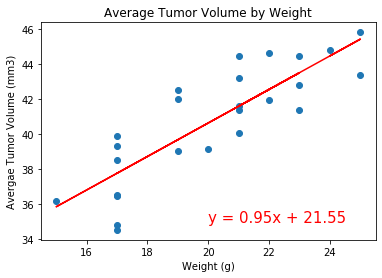

In [15]:
# Generate scatter plot from ^
merged_df = pd.merge(mouse_metadata,study_results, how='outer', on='Mouse ID')
capomulin_df = merged_df[merged_df['Drug Regimen'] == 'Capomulin']
avg_vol_df = pd.DataFrame(capomulin_df.groupby('Mouse ID')['Tumor Volume (mm3)'].mean().sort_values()).reset_index().rename(columns={'Tumor Volume (mm3)':'avg_tumor_vol'})
avg_vol_df = pd.merge(capomulin_df, avg_vol_df, on='Mouse ID')
final_avg_vol_df = avg_vol_df[['Weight (g)', 'avg_tumor_vol']].drop_duplicates()
x = final_avg_vol_df['Weight (g)']
y = final_avg_vol_df['avg_tumor_vol']
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen\
correlation = st.pearsonr(x,y)
print(f'The correlation between weight (g) and average tumor size (mm3) on the Capomulin regimen is {round(correlation[0],2)}.')
# Calculate linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))
# Plot linear regression on scatter plot
plt.scatter(x,y)
plt.plot(x,regress_values,'r-')
# Show equation
plt.annotate(line,(20,35),fontsize=15,color='red')
# Add labels
plt.xlabel('Weight (g)')
plt.ylabel('Avergae Tumor Volume (mm3)')
plt.title('Average Tumor Volume by Weight')
plt.show()